In [1]:
import matplotlib.pyplot as plt
import  numpy as np
from sklearn import datasets

In [2]:
class SOM(object):

    def __init__(self, x_grid_size, y_grid_size,input_dim, sigma=.8,
                 learning_rate=0.5, random_seed=777):

        self.sigma = sigma
        self.learning_rate = learning_rate
        self.random_instance = np.random.RandomState(random_seed)
        self.weights = self.random_instance.uniform(-1, 1, (x_grid_size,
                                                            y_grid_size,
                                                            input_dim))

        self.activation_map = np.zeros((x_grid_size,y_grid_size))
        self.x_coordinates = np.arange(x_grid_size)
        self.y_coordinates = np.arange(y_grid_size)
        self.neighborhood = self.gaussian

    def _decay_function(self, decaying_variable, iteration_index, temperature):
        return (decaying_variable * np.exp(-(iteration_index) / temperature))

    def _norm(self,x):
        return np.linalg.norm(x)

    def _activate(self,sample):
        grid_difference = np.subtract(sample, self.weights)
        iterator = np.nditer(self.activation_map, flags=['multi_index'])
        while not iterator.finished:
            self.activation_map[iterator.multi_index] = self._norm(
                                            grid_difference[iterator.multi_index])
            iterator.iternext()

    def activate(self,sample):
        self._activate(sample)
        return self.activation_map

    def gaussian(self,center,sigma):
        x_center = center[0]
        y_center = center[1]
        variance = sigma*sigma
        gaussian_x = np.exp(-np.power(self.x_coordinates-x_center,2)/(2*variance))
        gaussian_y = np.exp(-np.power(self.y_coordinates-y_center,2)/(2*variance))
        gaussian_neighborhood = np.outer(gaussian_x,gaussian_y)
        return gaussian_neighborhood

    def calculate_winner(self,sample):
        self._activate(sample)
        winner_arg = self.activation_map.argmin()
        winner_coordinates =  np.unravel_index(winner_arg, self.activation_map.shape)
        return winner_coordinates

    def update(self, sample, winner_coordinates, iteration_index):
        eta = self._decay_function(self.learning_rate, iteration_index, self.temperature)
        sig = self._decay_function(self.sigma,iteration_index, self.temperature)
        neighborhood_update = eta * self.neighborhood(winner_coordinates, sig)

        iterator = np.nditer(neighborhood_update, flags=['multi_index'])
        while not iterator.finished:
            self.weights[iterator.multi_index] = self.weights[iterator.multi_index] + \
                                                 neighborhood_update[iterator.multi_index]* \
                                                 (sample-self.weights[iterator.multi_index])
            iterator.iternext()

    def set_temperature(self, iteration_number):
        self.temperature = iteration_number/2

    def fit(self,data,number_of_iterations):
        self.set_temperature(number_of_iterations)
        for iteration in range(number_of_iterations):
            random_int = self.random_instance.randint(len(data))
            random_sample = data[random_int]
            self.update(random_sample,self.calculate_winner(random_sample),iteration)

## MNIST example

Training...


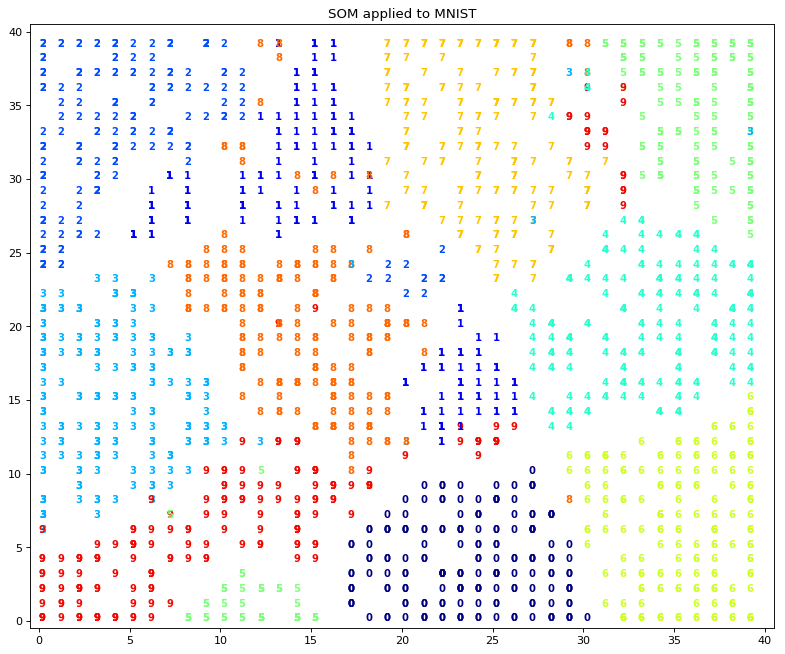

In [7]:
model = SOM(40, 40, 64, sigma=9, learning_rate=0.5)
digits = datasets.load_digits(n_class=10)
data = digits.data 
print("Training...")
model.fit(data, 20000)
numbers = digits.target
plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
for sample,number in zip(data, numbers):
    winner = model.calculate_winner(sample)
    x_coordinate = winner[0]
    y_coordinate = winner[1]
    num_colors = plt.cm.jet(number / 10)
    plt.text(x_coordinate, y_coordinate,
             str(number), color=num_colors,
             fontdict={'weight':'bold', 'size':9})

plt.ylim(-.5, 40.5)
plt.xlim(-.5, 40.5)
plt.title('SOM applied to MNIST')
plt.show()